In [1]:
import os
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import torch
import torch_geometric

from griphin.data import GrailDataModule
from griphin.model import GrailRegressor, load_model_from_path

# Settings for deterministic training
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(42)
seed_everything(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [2]:
# Define global variables
PROJECT_ROOT = os.path.dirname(os.getcwd())
MODEL = GrailRegressor
#VS_MODEL_NUMBER = "90"
#MODEL_PATH = os.path.join(PROJECT_ROOT, "logs", MODEL.__name__, f"version_{VS_MODEL_NUMBER}")
MODEL_PATH = os.path.join(PROJECT_ROOT, "trained_model", "griphin_model")
params = yaml.load(
    open(os.path.join(MODEL_PATH, "hparams.yaml"), "r"), Loader=yaml.FullLoader
)
#model = load_model_from_path(MODEL_PATH, MODEL)
model = MODEL.load_from_checkpoint(
            os.path.join(MODEL_PATH, "model.ckpt"), map_location=torch.device("cpu")
        )
DATASET_ROOT = os.path.join(PROJECT_ROOT, "data", params["data_set"])

# Load the model
trainer = Trainer(
    num_nodes=1,
    devices=1,
    accelerator="gpu",
    logger=False,
    log_every_n_steps=2,
)

# Setup datamodule
datamodule = GrailDataModule(
    DATASET_ROOT,
    batch_size=params["batch_size"],
    split=params["data_split"],
)
datamodule.setup()

/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1
/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/torch_geometric/nn/models/mlp.py:102: UserWarning: Argument `batch_norm` is deprecated, please use `norm` to specify normalization layer.
  warnings.warn("Argument `batch_norm` is deprecated, "
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of training graphs: 17237
Number of validation graphs: 1916
Number of test graphs: 290


6e92


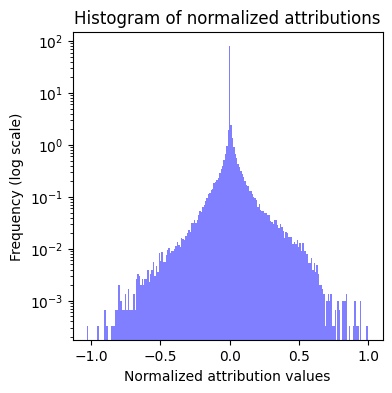

In [9]:
from griphin.visualization import Explainer
    
data_point = datamodule.validation_data[3]
explainer = Explainer(model, device="cuda:0")
attributions_normalized = explainer.calculate_attributions(data_point)
fig = plt.figure(figsize=(4, 4))
plt.hist(attributions_normalized.flatten(), bins=200, density=True, alpha=0.5, color='blue', log=True)
plt.title("Histogram of normalized attributions")
plt.xlabel("Normalized attribution values")
plt.ylabel("Frequency (log scale)")
plt.show()

In [ ]:
from griphin.visualization import Py3DmolViewer, InteractionWrapper

viewer = Py3DmolViewer(800, 600)
viewer.retrieve_files(data_point, DATASET_ROOT)
attribution_data = viewer.fit_padded_tensor_to_grid(attributions_normalized[0])
viewer.set_attribution_data(attribution_data)
viewer.create_initial_view(zoom_level=0.5)
viewer.view.show()
wrapper = InteractionWrapper()
wrapper.interaction(viewer)
# Example: Channel 5 evaluates how well a Ligand PI feature fits at this position given the NI features of the protein environment

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

interactive(children=(Dropdown(description='Channel:', options=('H-H', 'AR-AR', 'AR-PI', 'NI-PI', 'PI-AR', 'PI…